# Script to work with fixed macrophages

In [2]:
### conda install seaborn scikit-learn statsmodels numba pytables
### conda install -c conda-forge python-igraph louvain
### pip install scanpy

import pickle,numpy,pandas
import matplotlib,matplotlib.pyplot
import scanpy
scanpy.settings.verbosity=5

## 1. Read data files

In [3]:
### define input files
adata=scanpy.read_10x_mtx('/Volumes/omics4tb2/alomana/projects/i18/results/both_aggregated/outs/filtered_feature_bc_matrix',var_names='gene_symbols',cache=True)
adata.var_names_make_unique() 
adata

... reading from cache file ./cache/Volumes-omics4tb2-alomana-projects-i18-results-both_aggregated-outs-filtered_feature_bc_matrix-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


View of AnnData object with n_obs × n_vars = 1274 × 112137 
    var: 'gene_ids', 'feature_types'

## 2. Preprocess

In [4]:
scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

filtered out 9 cells that have less than 200 genes expressed
filtered out 84118 genes that are detected in less than 3 cells


### 2.1. Retrieve mouse cells only

In [5]:
cellIDs=adata.obs_names.tolist()
geneNames=adata.var_names.tolist()

jarFile='/Volumes/omics4tb2/alomana/projects/i18/results/jarFiles/species.cellIDs.run.006.pickle'
f=open(jarFile,'rb')
[mouseCellIDs,humanCellIDs,chimericCellIDs]=pickle.load(f)
f.close()

print(len(cellIDs),len(geneNames))
print('mouse',len(mouseCellIDs))
print('human',len(humanCellIDs))
print('chimeric',len(chimericCellIDs))

1265 28019
mouse 196
human 1024
chimeric 45


In [6]:
# slice in mouse cells
print('before slicing mouse cells...')
print(adata)
print()
adata=adata[mouseCellIDs,:]
print('after')
print(adata)

# slice in mouse genes
mouseGenes=[element for element in geneNames if element[:4] == 'mm10']
print()
print('before slicing mouse genes...')
print(adata)
print()
adata=adata[:,mouseGenes]
print('after')
print(adata)

before slicing mouse cells...
AnnData object with n_obs × n_vars = 1265 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

after
View of AnnData object with n_obs × n_vars = 196 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

before slicing mouse genes...
View of AnnData object with n_obs × n_vars = 196 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

after
View of AnnData object with n_obs × n_vars = 196 × 10891 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


### 2.2. Highly abundant genes

    normalizing by total count per cell
        finished (0:00:00.01): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


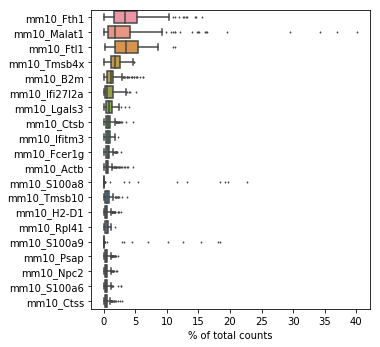

In [7]:
scanpy.pl.highest_expr_genes(adata,n_top=20)

### 2.3. QC based on mitochondrial genes and number of counts

... storing 'feature_types' as categorical


['mm10_mt-Rnr1', 'mm10_mt-Rnr2', 'mm10_mt-Nd1', 'mm10_mt-Nd2', 'mm10_mt-Co1', 'mm10_mt-Co2', 'mm10_mt-Atp8', 'mm10_mt-Atp6', 'mm10_mt-Co3', 'mm10_mt-Nd3', 'mm10_mt-Nd4', 'mm10_mt-Nd5', 'mm10_mt-Cytb']


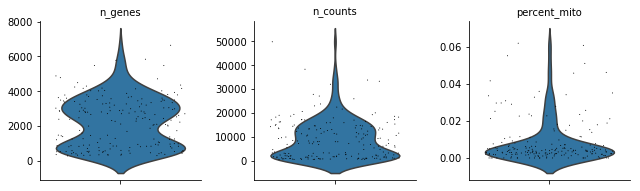

In [8]:
mitoGenes=[element for element in adata.var_names if element[:8] == 'mm10_mt-']
print(mitoGenes)

adata.obs['percent_mito']=numpy.sum(adata[:,mitoGenes].X,axis=1).A1/numpy.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.pl.violin(adata,['n_genes','n_counts','percent_mito'],jitter=0.4,multi_panel=True)

AnnData object with n_obs × n_vars = 196 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'


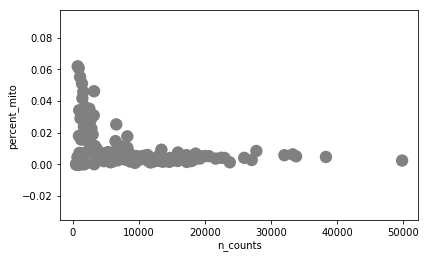

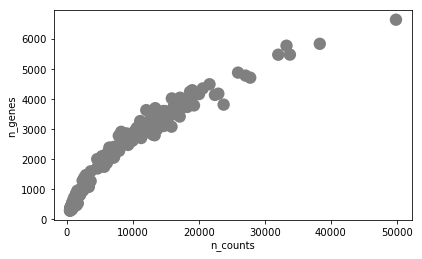

In [9]:
print(adata)
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

View of AnnData object with n_obs × n_vars = 187 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'


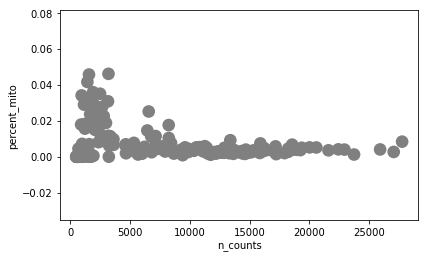

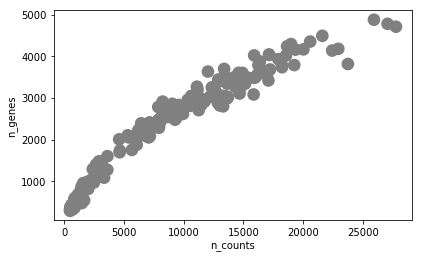

In [10]:
#adata = adata[adata.obs['n_counts'] > 10000, :]
adata = adata[adata.obs['n_counts'] < 30000, :]
#adata = adata[adata.obs['n_genes'] > 2000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

print(adata)
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

### 2.4. Normalization and log transform

In [11]:
#scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=30e3)

In [12]:
scanpy.pp.log1p(adata)

In [13]:
adata.raw = adata

    extracting highly variable genes
        finished (0:00:00.41)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


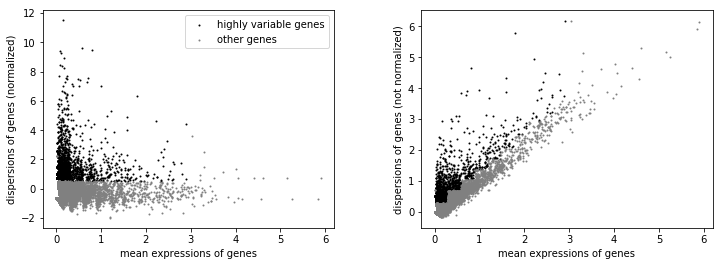

In [14]:
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [15]:
print(adata)
adata = adata[:,adata.var['highly_variable']]
print(adata)

AnnData object with n_obs × n_vars = 187 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
View of AnnData object with n_obs × n_vars = 187 × 2238 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


### 2.5. Regress out effects of total counts per cell and the percentage of mitochondrial genes  

In [16]:
#scanpy.pp.regress_out(adata,['n_counts','percent_mito'])

In [17]:
scanpy.pp.scale(adata,max_value=10)
print(adata)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10
AnnData object with n_obs × n_vars = 187 × 2238 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


### 2.6. Associate treatment to cell ID

In [18]:
cellIDs=adata.obs_names.tolist()
print(len(cellIDs))

cellConditions=[]
for cellID in cellIDs:
    if '-1' in cellID: 
        cellConditions.append('fixed')
    elif '-2' in cellID:
        cellConditions.append('fresh')
    else:
        raise ValueError('cellID not recognized')
    
print(cellConditions,len(cellConditions))
print('number of fixed cells:',cellConditions.count('fixed'))
print('number of fresh cells:',cellConditions.count('fresh'))
observedRatio=cellConditions.count('fixed')/cellConditions.count('fresh')
expectedRatio=413/861
print('observed ratio:{:.3f}, expected ratio:{:3f}'.format(observedRatio,expectedRatio))

187
['fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fres

## 3. Visualization

## 3.1. PCA

In [19]:
print(adata)

AnnData object with n_obs × n_vars = 187 × 2238 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [20]:
scanpy.tl.pca(adata, svd_solver='arpack')

    computing PCA with n_comps = 50
        finished (0:00:00.06)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


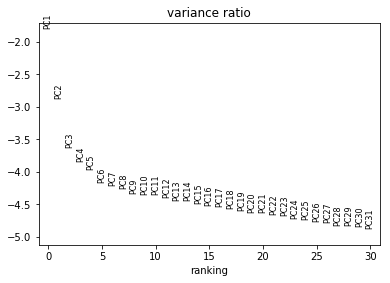

In [21]:
scanpy.pl.pca_variance_ratio(adata, log=True)

... storing 'treatment' as categorical


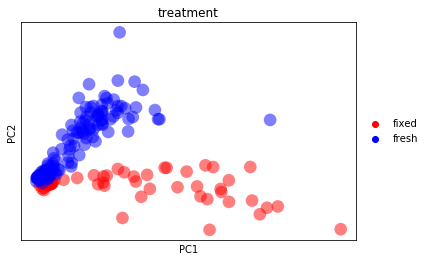

In [22]:
adata.obs['treatment']=cellConditions
scanpy.pl.pca(adata,color='treatment',palette=['red','blue'],alpha=0.5)

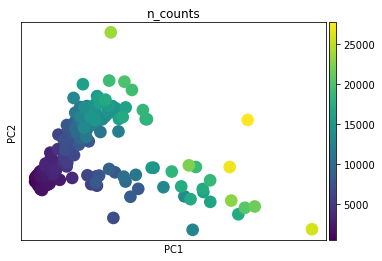

In [23]:
scanpy.pl.pca(adata,color='n_counts',palette='viridis')

In [24]:
print(adata)

AnnData object with n_obs × n_vars = 187 × 2238 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'treatment'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'treatment_colors'
    obsm: 'X_pca'
    varm: 'PCs'


## 3.2. UMAP

computing neighbors
    using 'X_pca' with n_pcs = 30
    computed neighbors (0:00:00.00)
    computed connectivities (0:00:02.80)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished (0:00:01.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)


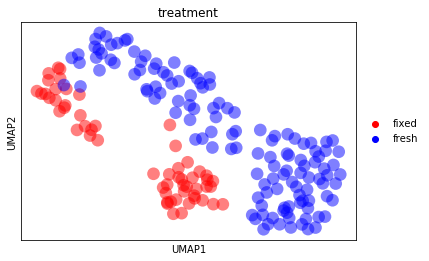

In [25]:
scanpy.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color='treatment',alpha=0.5)

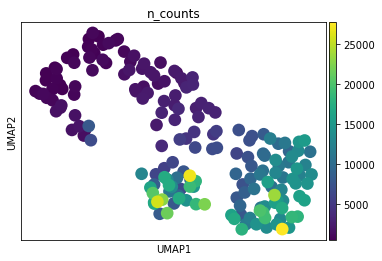

In [26]:
scanpy.pl.umap(adata, color='n_counts',palette='bwr')

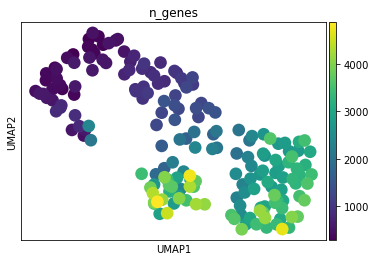

In [27]:
scanpy.pl.umap(adata, color='n_genes',palette='viridis')

## 3.3 Louvain

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


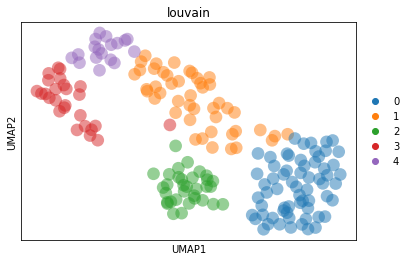

In [28]:
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata, color=['louvain'],alpha=0.5)

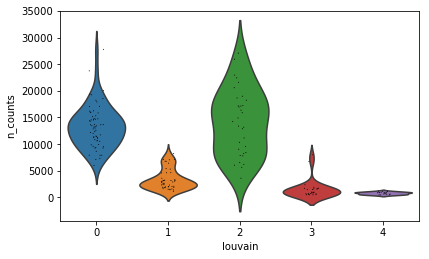

In [30]:
scanpy.pl.violin(adata,keys=['n_counts'],groupby='louvain',use_raw=True)

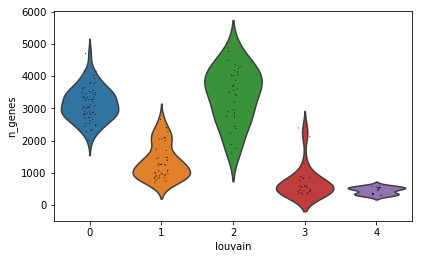

In [31]:
scanpy.pl.violin(adata,keys=['n_genes'],groupby='louvain',use_raw=True)

# 4. Find markers

ranking genes
    consider 'louvain' groups: ['0' '1' '2' '3' '4']
    with sizes: [64 46 33 26 18]
    finished (0:00:00.20) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


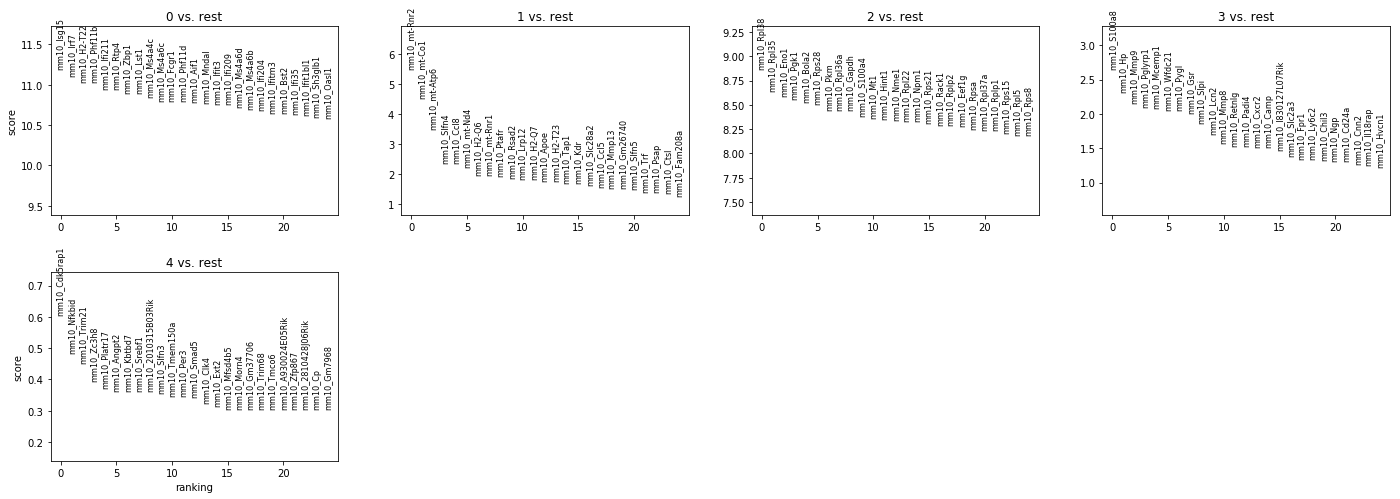

In [28]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [29]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(10)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,3_p,3_l,4_n,4_p,4_l
0,mm10_Isg15,2.584300e-25,1.663342,mm10_mt-Rnr2,0.000003,0.744995,mm10_Rpl38,4.220317e-15,1.833152,mm10_S100a8,0.050493,3.214866,mm10_Cdk5rap1,0.948054,2.034045
1,mm10_Irf7,4.497449e-25,1.867448,mm10_mt-Co1,0.000153,0.812491,mm10_Rpl35,2.067452e-14,1.738211,mm10_Hp,0.107176,3.615156,mm10_Nfkbid,0.948054,1.423599
2,mm10_H2-T22,5.783955e-25,2.267584,mm10_mt-Atp6,0.006104,0.551221,mm10_Eno1,2.372795e-14,2.657618,mm10_Mmp9,0.146519,5.769712,mm10_Trim21,0.948054,0.856849
3,mm10_Phf11b,5.783955e-25,2.415973,mm10_Slfn4,0.114509,0.640282,mm10_Pgk1,2.372795e-14,2.623767,mm10_Pglyrp1,0.164496,4.519695,mm10_Zc3h8,0.948054,0.884717
4,mm10_Ifi211,1.115890e-24,2.186909,mm10_Ccl8,0.116277,0.725210,mm10_Bola2,2.684562e-14,1.950087,mm10_Mcemp1,0.167049,4.291849,mm10_Platr17,0.948054,0.977942
5,mm10_Rtp4,1.115890e-24,1.730536,mm10_mt-Nd4,0.147547,0.367660,mm10_Rps28,2.684562e-14,1.377281,mm10_Wfdc21,0.176465,4.049619,mm10_Angpt2,0.948054,0.909026
6,mm10_Zbp1,1.389141e-24,2.281929,mm10_H2-Q6,0.242059,0.574547,mm10_Pkm,3.251334e-14,1.564273,mm10_Pygl,0.180169,2.511989,mm10_Kbtbd7,0.948054,0.909026
7,mm10_Lst1,1.389141e-24,1.409015,mm10_mt-Rnr1,0.242852,0.507546,mm10_Rpl36a,3.251334e-14,1.791757,mm10_Gsr,0.193782,1.416378,mm10_Srebf1,0.948054,0.909026
8,mm10_Ms4a4c,2.262568e-24,1.768353,mm10_Ptafr,0.254213,0.364759,mm10_Gapdh,3.251334e-14,1.636238,mm10_Slpi,0.247474,2.357405,mm10_2010315B03Rik,0.948054,0.909026
9,mm10_Ms4a6c,3.092291e-24,1.581282,mm10_Rsad2,0.287540,0.406681,mm10_S100a4,5.249207e-14,1.811978,mm10_Lcn2,0.321412,3.850474,mm10_Slfn3,0.948054,0.827010


ranking genes
    consider 'louvain' groups: ['2' '0']
    with sizes: [33 64]
    finished (0:00:00.09) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


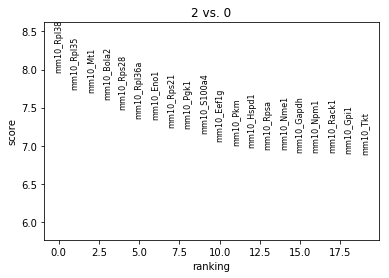

In [30]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['2'], reference='0', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['2'], n_genes=20)

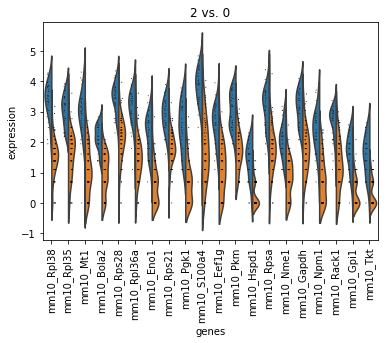

In [31]:
scanpy.pl.rank_genes_groups_violin(adata, groups='2', n_genes=20)

ranking genes
    consider 'louvain' groups: ['4' '0']
    with sizes: [18 64]
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished (0:00:00.07) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


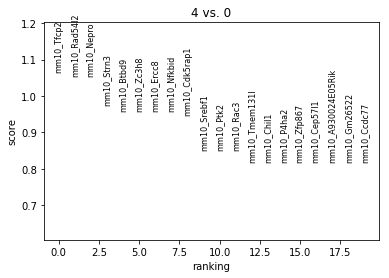

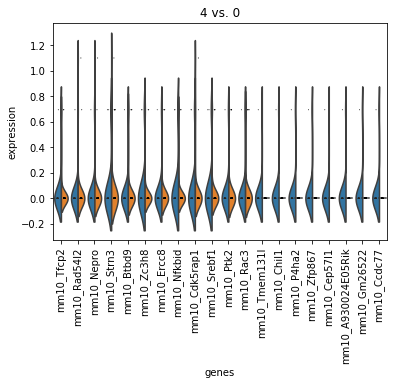

In [32]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['4'], reference='0', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['4'], n_genes=20)
scanpy.pl.rank_genes_groups_violin(adata, groups='4', n_genes=20)